<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

---
---
# **🩺 Towards Precision Medicine Section 3:  Creating an Expert-Level Diagnostic Model**

In Notebook 2, we built our first foundational model. While its performance was significantly better than random chance, it was likely overfitting, and its validation accuracy was unstable and not yet high enough for a real-world medical application.. This tells us that classifying these tissue types is a very complex problem, and our simple CNN likely isn't powerful enough on its own to learn the subtle patterns needed to reliably distinguish all eight classes.

To create a truly expert-level model, we need to improve both its robustness (its ability to handle real-world variations) and its "vision" (its ability to extract more complex features).

In this final notebook, we will use two powerful, standard techniques to achieve this:

1. Data Augmentation: To improve robustness by teaching our model to handle the natural variability in medical images.
2. Transfer Learning: To dramatically improve the model's "vision" by leveraging the knowledge of a pre-trained expert AI.

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown ##**BEFORE RUNNING ANY CODE, please change your Hardware Accelerator to GPU to run code much faster!**</h2>
#@markdown 1. Click on the **Runtime** menu at the top of the screen.
#@markdown 2. Click **Change Runtime Type**.
#@markdown 3. Choose **T4 GPU** under **Hardware Accelerator**.

#@markdown Once you've done that, run this code cell to check you're correctly connected!

import tensorflow as tf
from IPython.display import Markdown

if tf.test.gpu_device_name():
  display(Markdown("###✅ GPU connected!"))
else:
  display(Markdown("""
###❌ No GPU found!
If you're running into GPU limits when you try to switch, here are some suggestions:
  - Wait 12-24 hours for the limits to reset.
  - Share your copy of the notebook with another Google account that hasn't met the limit, and work through the notebook with that account.
    - You can share by clicking on the "Share" menu on the top right, adding the other Google email, and making them an editor.
  - If you're using Colab's GPUs extensively and want to avoid the limits completely, look into a paid subscription or paying for compute units as you go.
  """))

###✅ GPU connected!

In [ ]:
#@title **🏗 Setup Cell** {"display-mode":"form", "form-width":"25%"}
#@markdown **Run this to import libraries and download data!**

import random
from IPython.display import Markdown, display, clear_output

import numpy as np
np.random.seed(1)

import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Inspirit's util file and discussion exercise answer handler
import os
if not os.path.exists('inspiritai_util.py'):
    !wget -q "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Modules/inspiritai_util.py"
from inspiritai_util import handle_discussion_response

# Data download
download_url = "https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/Project%20-%20Towards%20Precision%20Medicine/"

wget_command = f'wget -q --show-progress "{download_url}'
!{wget_command + 'images.npy" '}
!{wget_command + 'labels.npy" '}

images = np.load('images.npy')
labels = np.load('labels.npy')

!rm images.npy labels.npy

def plot_metric(history, metric="accuracy", best_is_max=True, start_epoch=0, random_model_metric=None):
  # Get lists of accuracies over the epochs
  training_accuracy = history.history[metric][start_epoch:]
  validation_accuracy = history.history['val_' + metric][start_epoch:]

  # Find best epoch depending on whether max is the best for the metric
  if best_is_max:
    best_epoch = validation_accuracy.index(max(validation_accuracy))
  else:
    best_epoch = validation_accuracy.index(min(validation_accuracy))

  # Plot labels
  plt.title(metric.capitalize() + ' as Model Trains')
  plt.xlabel('Epoch #')
  plt.ylabel(metric.capitalize())

  # Plot lines
  plt.plot(training_accuracy, label='Train')
  plt.plot(validation_accuracy, label='Validation')
  plt.axvline(x=best_epoch, linestyle='--', color='green', label='Best Epoch')

  if random_model_metric is not None:
    plt.axhline(random_model_metric, linestyle='--',color='red', label='Chance')

  # Plot legend and show
  plt.legend()
  plt.show()


# This code is adapted from the Keras documentation.
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates a class activation heatmap.

    Args:
        img_array (numpy.array): The input image array, preprocessed for the model.
        model (keras.Model): The trained model.
        last_conv_layer_name (str): The name of the last convolutional layer in the model.
        pred_index (int, optional): The index of the class to generate the heatmap for.
                                   If None, the model's top prediction is used.

    Returns:
        numpy.array: The generated heatmap.
    """
    # Create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Use GradientTape to compute the gradient of the top predicted class
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purposes, we will normalize the heatmap between 0 & 1
    # Add a small epsilon to avoid division by zero
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

def display_gradcam(img, heatmap, alpha=0.6):
    """
    Overlays the heatmap on the original image.

    Args:
        img (numpy.array): The original image.
        heatmap (numpy.array): The heatmap generated by make_gradcam_heatmap.
        alpha (float): The transparency of the heatmap overlay.

    Returns:
        numpy.array: The image with the heatmap superimposed.
    """
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    # Note: We use plt.get_cmap() to avoid the MatplotlibDeprecationWarning
    jet = plt.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    return superimposed_img

def plot_single_gradcam(image_index, model, last_conv_layer, class_names_list, X_data, y_data):
    """Helper function to generate and plot a single Grad-CAM visualization."""
    test_image = X_data[image_index]
    img_array = np.expand_dims(test_image, axis=0)

    true_label_index = np.argmax(y_data[image_index])
    true_label_name = class_names_list[true_label_index]

    preds = model.predict(img_array, verbose=0)
    predicted_label_index = np.argmax(preds[0])
    predicted_label_name = class_names_list[predicted_label_index]

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer)
    superimposed_img = display_gradcam(test_image.astype(float), heatmap)

    plt.figure(figsize=(8, 4))
    plt.suptitle(f"Image Index #{image_index} - True: {true_label_name} | Predicted: {predicted_label_name}", fontsize=14)
    plt.subplot(1, 2, 1)
    plt.imshow(test_image)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


images.npy          100%[===================>] 527.34M   187MB/s    in 2.8s    
labels.npy          100%[===================>]  28.12K  --.-KB/s    in 0.001s  


## Table of Contents

You can find a more detailed Table of Contents by clicking on the icon on the left sidebar that looks like this: <img src="https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Google%20Colab%20Tutorial/Table%20of%20Contents.png" width=20>.


>[📏 Milestone 1: Establishing Our Baseline Model](#scrollTo=TG12lEgCLUr3)

>>[1.1. Revisiting Our Inputs and Outputs](#scrollTo=NYckpt5DMH74)

>>[1.2. Revisiting Our Model](#scrollTo=QVEjbfG7d-Ow)

>[📈 Milestone 2: Improving our Model with Data Augmentation](#scrollTo=ccWkQbhWOA82)

>>[2.1. Exploring and Applying Data Augmentation](#scrollTo=T9QydaCOOfRG)

>>[2.2. Creating the Data Augmentation Function](#scrollTo=1tpqo9rgOlFO)

>>[2.3. Retraining the Model on Our Expanded Dataset](#scrollTo=CiX2A2qQQIpt)

>[🧠 Milestone 3: Improving our Model with Transfer Learning](#scrollTo=Nf7_KeRDQYtz)

>>[3.1. Building the Transfer Model](#scrollTo=L53eEc-z2p0T)

>[🤔 Milestone 4: Model Interpretability with Grad-CAM](#scrollTo=OWK31rK6TD9L)

>>[4.1. Interactive Model Interpretability: Grad-CAM](#scrollTo=s4Ih4UWKUBMR)

>[🎁 Wrapping Up](#scrollTo=aKfYLEEBTdba)




---
---
# **📏 Milestone 1: Establishing Our Baseline Model**

To accurately measure the impact of our new techniques, we first need to re-establish our baseline. The code cell below handles all the essential steps from Notebook 2: it preprocesses the data and rebuilds the same simple CNN we created previously.

Before we dive into advanced techniques, let's quickly review our baseline model from Notebook 2 and, more importantly, understand what it's actually doing under the hood. When we ask our model to predict, it doesn't output the word `tumor` or `stroma`. Instead, it outputs a vector of probabilities.

After running the following cell, you will have the variables `X_train`, `X_test`, `y_train`, and `y_test` along with your initialized (but untrained!) model, `cnn`.

In these exercises, we will take a single image from our test set and walk through the exact steps required to turn the model's raw numerical output into a final, human-readable label.


In [ ]:
#@title Run this cell to construct your model! {"display-mode":"form", "form-width":"25%"}
#@markdown Feel free to click "Show code" and edit the model with any improvements you may have made in Notebook 2!
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Conv3D, Flatten, Dropout

# Using the get_dummies() function to one-hot encode your labels.
labels_ohe = np.array(pd.get_dummies(labels))

# Select your feature (X) and labels (y).
y = labels_ohe
X = images / 255.

# Split your data into training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

# Initialize your model
def construct_model():
  cnn = Sequential()

  # Input layer
  cnn.add(Input(shape=X_train.shape[1:]))

  # First layer
  cnn.add(Conv2D(8, (3,3), activation='relu', padding="same"))
  cnn.add(MaxPooling2D((2, 2)))

  # Second layer
  cnn.add(Conv2D(16, (3,3), activation='relu', padding="same"))
  cnn.add(MaxPooling2D((2, 2)))

  # Third layer
  cnn.add(Conv2D(32, (3,3), activation='relu', padding="same"))
  cnn.add(MaxPooling2D((2, 2)))

  # # Fourth layer
  cnn.add(Conv2D(64, (3,3), activation='relu', padding="same"))
  cnn.add(MaxPooling2D((2, 2)))

  # Flattening layer
  cnn.add(Flatten())

  # Hidden (dense) layer with 32 nodes, and relu activation function.
  cnn.add(Dense(32, activation='relu'))

  # Dropout layer with 50% dropout rate
  cnn.add(Dropout(0.15))

  # Final output layer that uses a softmax activation function.
  cnn.add(Dense(len(set(labels)), activation='softmax'))

  # Compile your model
  metrics_to_track = ['categorical_crossentropy', 'accuracy']
  cnn.compile(loss='categorical_crossentropy',
                optimizer='rmsprop',
                metrics=metrics_to_track)
  return cnn

cnn = construct_model()

## **1.1. Revisiting Our Inputs and Outputs**

### 1.1.1. Coding Exercise: Reviewing the Train-Test Split



Print the shapes of `X_train`, `X_test`, `y_train`, and `y_test`.

In [ ]:
# Print the shapes of our training and testing data

### WRITE YOUR CODE BELOW: Replace the Nones!
print('shape of training images:', X_train.shape)
print('shape of training labels:', y_train.shape)
print('shape of testing images:', X_test.shape)
print('shape of testing labels:', y_test.shape)

shape of training images: (768, 150, 150, 3)
shape of training labels: (768, 8)
shape of testing images: (256, 150, 150, 3)
shape of testing labels: (256, 8)


### 1.1.2 Discussion Exercise: Reviewing the Data's Shape


In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *1. What do each of the values in the shape `X_train` mean?*
answer1 = '' #@param {type:"string"}

#@markdown *2. Why does the shape of our training labels (`y_train`) have two values?*
answer2 = '' #@param {type:"string"}

handle_discussion_response(answer1, answer2)

Please input your responses in the answer boxes above!


### 1.1.3. Coding Exercise: Displaying Our Outputs


In the hidden code cell below, we define the function `probability_vector_to_predictions()`, which takes in a one-hot encoded vector from our labels and returns the category assigned to it.


In [ ]:
#@title Run this to define the `probability_vector_to_predictions()` function! {"display-mode":"form", "form-width":"25%"}
#@markdown Feel free to reveal the code and discuss if you're curious.

# dictionary that converts the one-hot encoded label indice into the label name
one_hot_encoding_to_label_dict = {np.argmax(ohe):label for ohe, label in zip(labels_ohe, labels)}

def probability_vector_to_predictions(prob_vector):
  class_num = np.argmax(prob_vector) # Find which element in the vector has the highest score.
  class_name = one_hot_encoding_to_label_dict[class_num] # Figure out the label that corresponds to this element.
  return class_name, max(prob_vector) # Return the label as well as the probabilty that the model assigned to this prediction.

Let's now analyze `y_test`! Print the first 3 values of `y_test`, along with the categorical labels. `probability_vector_to_predictions()` will be helpful here!

In [ ]:
### WRITE YOUR CODE BELOW
for i in range(3):
  print(y_test[i])
  print(probability_vector_to_predictions(y_test[i]))

[False False False  True False False False False]
(np.str_('empty'), np.True_)
[False  True False False False False False False]
(np.str_('complex'), np.True_)
[False  True False False False False False False]
(np.str_('complex'), np.True_)


### 1.1.4. Discussion Exercise: Analyzing Our Outputs


In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *1. What are our `y` values?*
answer1 = "The y values are where the vectors are \"hot\" because it is the predictions " #@param {type:"string"}

#@markdown *2. How does the model interpret them (i.e. how is the model interpreting a list of `1`s and `0`s)?*
answer2 = 'The y values are the output layers, and for the interpreting it looks at them like booleans. ' #@param {type:"string"}

handle_discussion_response(answer1, answer2)

Your answers:

------------------------------1------------------------------
The y values are where the vectors are "hot" because it is
the predictions
-------------------------------------------------------------

------------------------------2------------------------------
The y values are the output layers, and for the interpreting
it looks at them like booleans.
-------------------------------------------------------------

If you haven't already, discuss with your classmates!


## **1.2. Revisiting Our Model**



Before we train our model, let's see what it predicts for an image. An "untrained" model has random initial weights, so its predictions will be essentially random guesses. This gives us a baseline to see how much the model learns during training.

Before you run the code, what do you expect the model's output to look like for a random image?

 - Will the prediction be correct?

 - Will the model be confident in its prediction?

In [ ]:
# Get an image index from our test set
sample_image = X_test[8]
true_label_index = np.argmax(y_test[8])

# The model expects a "batch" of images (i.e. multiple images at once), so we add an extra dimension
sample_image_expanded = np.expand_dims(sample_image, axis=0)

# Get the model's raw prediction. NOTE: The model is UNTRAINED, so this is a random guess.
prediction = cnn.predict(sample_image_expanded, verbose=0)

# Decoding the Untrained Model's Guess
print(f"The model's raw output for the image is a vector of {len(prediction[0])} numbers:\n")
print(prediction[0])

print("\nEven though the model is just guessing, the 'softmax' layer still forces the numbers to look like probabilities.")
print(f"They all add up to: {np.sum(prediction[0]):.2f}\n")

The model's raw output for the image is a vector of 8 numbers:

[0.13309108 0.12743646 0.13746955 0.1026641  0.1187024  0.12304711
 0.12081955 0.1367698 ]

Even though the model is just guessing, the 'softmax' layer still forces the numbers to look like probabilities.
They all add up to: 1.00



The highest value in the random vector is at index: 2
--> This corresponds to the random guess: 'debris'
--> The model's confidence in its random guess is: 13.75%

Notice that the prediction is likely incorrect and the confidence is low. This is what we expect from an untrained model!


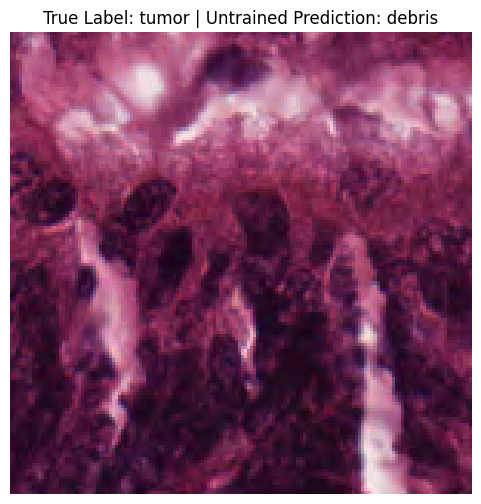

In [ ]:
#@title Run this cell to see the model's prediction and confidence {"display-mode":"form", "form-width":"25%"}

# Find the index of the highest probability in the random vector
predicted_index = np.argmax(prediction)
predicted_confidence = np.max(prediction)

# Define our class names in the correct order
class_names = sorted(pd.get_dummies(labels).columns)
true_label_name = class_names[true_label_index]

# Map the index to the class name
predicted_label_name = class_names[predicted_index]

print(f"The highest value in the random vector is at index: {predicted_index}")
print(f"--> This corresponds to the random guess: '{predicted_label_name}'")
print(f"--> The model's confidence in its random guess is: {predicted_confidence:.2%}\n")
print("Notice that the prediction is likely incorrect and the confidence is low. This is what we expect from an untrained model!")


# Visualize
plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
plt.title(f"True Label: {true_label_name} | Untrained Prediction: {predicted_label_name}", fontsize=12)
plt.axis("off")
plt.show()

### 1.2.1. Coding Exercise: Examining Our Model


Use the `.summary()` method to look at the architecture of your model. How many convolutional layers does your model contain? How many total parameters/weights will it be learning?

In [ ]:
### WRITE YOUR CODE BELOW
cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       165,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,712 (744.97 KB)

 Trainable params: 190,712 (744.97 KB)

 Non-trainable params: 0 (0.00 B)

### 1.2.2. Coding Exercise: Training Our Model



Retrain your model using your training data. Train your model for 20 epochs. Be sure to include the testing data as your `validation_data` and plot the model training history using `plot_metric()`.

In [ ]:
### WRITE YOUR CODE BELOW
history = cnn.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                        epochs=20,
                        batch_size=64)


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.1434 - categorical_crossentropy: 2.0751 - loss: 2.0751 - val_accuracy: 0.2891 - val_categorical_crossentropy: 1.9529 - val_loss: 1.9529
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2465 - categorical_crossentropy: 1.9426 - loss: 1.9426 - val_accuracy: 0.2656 - val_categorical_crossentropy: 1.8297 - val_loss: 1.8297
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2460 - categorical_crossentropy: 1.8545 - loss: 1.8545 - val_accuracy: 0.2500 - val_categorical_crossentropy: 1.7740 - val_loss: 1.7740
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.2491 - categorical_crossentropy: 1.8487 - loss: 1.8487 - val_accuracy: 0.2461 - val_categorical_crossentropy: 1.7194 - val_loss: 1.7194
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2562 - categorical_crossentropy: 1.7993 - loss: 1.7993 - val_accuracy: 0.3398 - val_categorical_crossentropy: 1.6495 - val_loss: 1

In [ ]:
# Let's predict on that same image again (change this if you changed the one above)
sample_image = X_test[8]
true_label_index = np.argmax(y_test[8])

--- Decoding the Trained Model's Guess ---

The model's raw output for the image:

[1.5274500e-03 2.4517938e-01 1.1286367e-02 1.1156821e-04 2.0090976e-01
 1.9456670e-01 1.7933225e-02 3.2848552e-01] 

The highest value in the vector is at index: 7
--> This corresponds to the: 'tumor' label
--> The model's confidence in its prediction is: 32.85%

How did the trained model do?


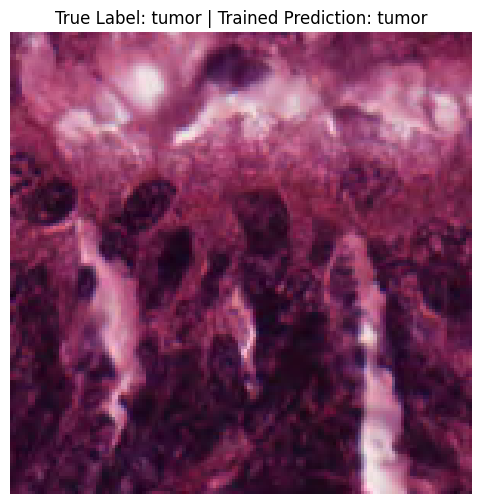

In [ ]:
#@title Run this cell to see the trained model's outputs, prediction, and confidence {"display-mode":"form", "form-width":"25%"}
# The model expects a "batch" of images (i.e. multiple images at once), so we add an extra dimension
sample_image_expanded = np.expand_dims(sample_image, axis=0)

# Get the model's prediction.
prediction_vector = cnn.predict(sample_image_expanded, verbose=0)


print("--- Decoding the Trained Model's Guess ---\n")
print(f"The model's raw output for the image:\n")
print(prediction_vector[0],"\n")

# 5. Find the index of the highest probability in the random vector
predicted_index = np.argmax(prediction_vector)
predicted_confidence = np.max(prediction_vector)

# 6. Map the index to the class name
predicted_label_name = class_names[predicted_index]

print(f"The highest value in the vector is at index: {predicted_index}")
print(f"--> This corresponds to the: '{predicted_label_name}' label")
print(f"--> The model's confidence in its prediction is: {predicted_confidence:.2%}\n")
print("How did the trained model do?")


# --- Let's visualize it all ---
plt.figure(figsize=(6, 6))
plt.imshow(sample_image)
plt.title(f"True Label: {true_label_name} | Trained Prediction: {predicted_label_name}", fontsize=12)
plt.axis("off")
plt.show()

### 1.2.3. Discussion Exercise: Analyzing the Results

Now that you've seen the whole process, discuss the following with your group.

In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *1. **Compare the Predictions**: Look at the outputs from the untrained vs. trained models. Did the model's prediction for the sample image change after training? Was the final prediction correct?*
answer1 = "The models prediction for the image didn't change and it was right both times. " #@param {type:"string"}

#@markdown *2. **Analyze the Confidence**: How did the model's confidence in its prediction change after training? Why is a high confidence score on a correct prediction a good sign?*
answer2 = 'It went from about 13% - 39%' #@param {type:"string"}

#@markdown *3. **Evaluate the Training Process**: Examine the accuracy and loss plots. At which epoch did the validation accuracy (the orange line) appear to be at its highest? What does this tell you about the ideal training time for this model?*
answer3 = 'At epoch 19 & 20 the validation accuracy appeared to be at its highest. This tells us that the ideal training time for this model is good for now. ' #@param {type:"string"}

#@markdown *4. **Assess Clinical Readiness**: In a clinical setting, a diagnostic tool must be extremely reliable (often >99% accurate) and stable. Look at your validation accuracy plot. Is the accuracy consistently high, or does it fluctuate? Why would a validation accuracy that is below 95% and unstable make this baseline model unsuitable for helping a pathologist make a real patient diagnosis?*
answer4 = 'The validation accuacy does flucuate a bit. This model is unsuitable for helping a pathologist make a real patient diagnosis ' #@param {type:"string"}

#@markdown *5. **Bonus**: Go to show code above and change the index. Look for examples where the model's confidence is high and when it is less certain. Are there any tissue types where the model is generally more or less certain?*
answer5 = '' #@param {type:"string"}


handle_discussion_response(answer1, answer2, answer3, answer4, answer5)

Your answers:

------------------------------1------------------------------
The models prediction for the image didn't change and it was
right both times.
-------------------------------------------------------------

------------------------------2------------------------------
It went from about 13% - 39%
-------------------------------------------------------------

------------------------------3------------------------------
At epoch 19 & 20 the validation accuracy appeared to be at
its highest. This tells us that the ideal training time for
this model is good for now.
-------------------------------------------------------------

------------------------------4------------------------------
The validation accuacy does flucuate a bit. This model is
unsuitable for helping a pathologist make a real patient
diagnosis
-------------------------------------------------------------

------------------------------5------------------------------
No response! Input your answer above.
-----

---
---
# **📈 Milestone 2: Improving our Model with Data Augmentation**

As we saw in our baseline model analysis, while the trained model is far better than a random guess, its performance isn't yet at the level required for clinical use. The validation accuracy likely fluctuated and peaked well below the 95-99% standard needed for a reliable diagnostic tool.

This tells us that our simple CNN, trained on our limited dataset, struggled to learn all the complex and subtle visual patterns needed to reliably distinguish between the eight tissue types.

One of the primary reasons for this is that our model hasn't seen enough examples to **generalize** well. In the real world, histology slides can have variations in staining, orientation, and lighting. To build a more robust model, we need to teach it to recognize the key tissue features regardless of these variations.

This is where **data augmentation** comes in.

Data augmentation is a powerful and essential technique in medical imaging. Since collecting and annotating thousands of new medical images is incredibly expensive and time-consuming, we can instead programmatically create new, slightly modified versions of the images we already have. By training our model on these "augmented" images (e.g., flipped, rotated, or zoomed), we teach it to become insensitive to these variations and focus only on the true underlying pathology.

In this section, we'll implement data augmentation to see if we can create a more robust and accurate model.

<center>
<img src="http://ai.stanford.edu/blog/assets/img/posts/2020-04-20-data-augmentation/thumbnail.png" width=500>

*Example of several ways you can augment a single image*

</center>

## **2.1. Exploring and Applying Data Augmentation**

This exercise is broken into two steps. First, we'll explore some common ways to augment histology images. Then, you'll apply these techniques to build a new, larger training dataset.

**Step 1: Exploring Different Augmentation Techniques**

Let's look at four simple but effective ways to augment our images. We'll apply each one to a random sample image to see the effect.

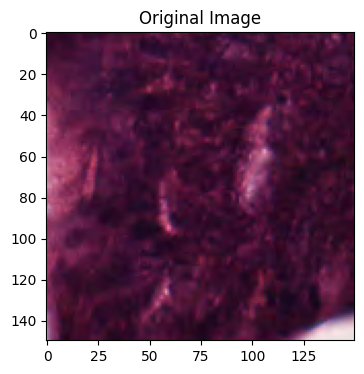

In [ ]:
## Rerun this cell to see a different image each time!
from numpy import flipud, fliplr
from skimage.transform import rotate
from skimage.exposure import adjust_gamma

original_image = X_train[np.random.randint(len(X_train))]
plt.figure(figsize=(8, 4))
plt.imshow(original_image)
plt.title('Original Image')
plt.show()

--- 1. Vertical Flip ---


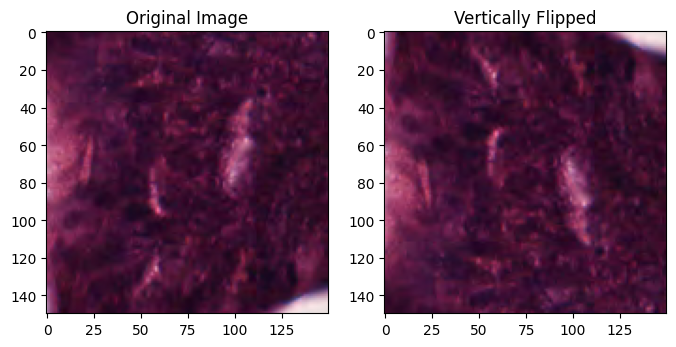

In [ ]:
# Example 1: Flipping Upside Down (flipud)
print("--- 1. Vertical Flip ---")
augmented_ud = flipud(original_image)

f, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[1].imshow(augmented_ud)
ax[1].set_title('Vertically Flipped')
plt.show()


--- 2. Horizontal Flip ---


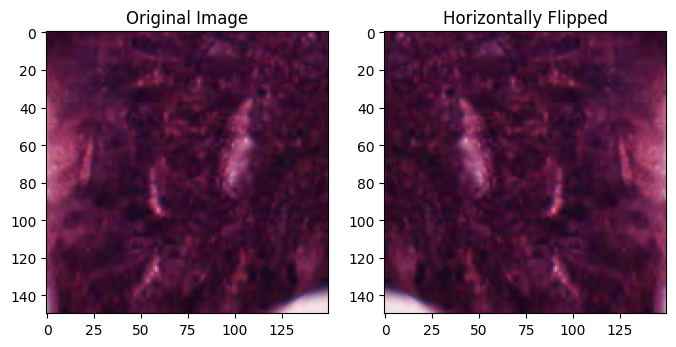

In [ ]:
# Example 2: Flipping Left-to-Right (fliplr)
print("\n--- 2. Horizontal Flip ---")
augmented_lr = fliplr(original_image)

f, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[1].imshow(augmented_lr)
ax[1].set_title('Horizontally Flipped')
plt.show()


--- 3. Rotation ---


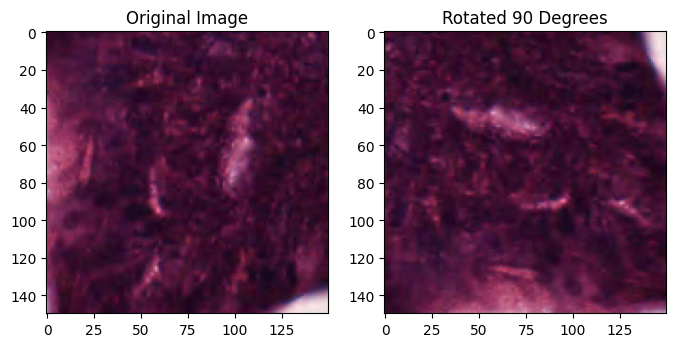

In [ ]:
# Example 3: Rotation
print("\n--- 3. Rotation ---")
# We rotate by 90 degrees. resize=False is important to keep the image dimensions the same.
augmented_rot = rotate(original_image, angle=90, resize=False)

f, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[1].imshow(augmented_rot)
ax[1].set_title('Rotated 90 Degrees')
plt.show()


--- 4. Brightness Change ---


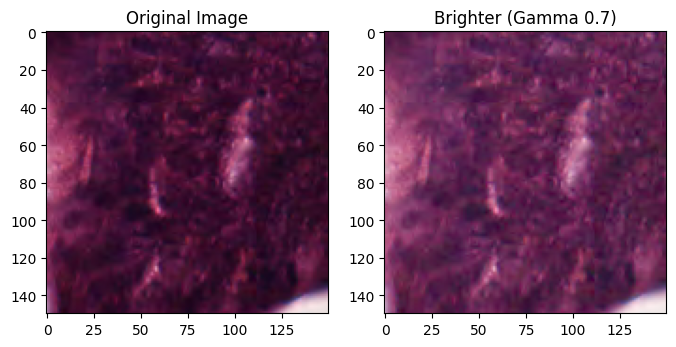

In [ ]:
# Example 4: Brightness Change (Gamma Correction)
print("\n--- 4. Brightness Change ---")
# Gamma < 1 makes the image brighter. Gamma > 1 makes it darker.
augmented_bright = adjust_gamma(original_image, gamma=0.7)

f, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].imshow(original_image)
ax[0].set_title('Original Image')
ax[1].imshow(augmented_bright)
ax[1].set_title('Brighter (Gamma 0.7)')
plt.show()

## **2.2. Creating the Data Augmentation Function**

### 2.2.1. Coding Exercise

Complete the function `create_random_augmented_image()`, which takes in an image and applies one of the four transformations to that image at random.

In [24]:
import random

# A function that randomly applies one of several augmentations
def create_random_augmented_image(original_image):

    # Randomly choose which augmentation to apply
    choice = random.randint(0, 3)

    if choice == 0:
        # Option 0: Flip upside down
        new_image = flipud(original_image)
    elif choice == 1:
        # Option 1: Flip left-to-right
        new_image = fliplr(original_image)
    elif choice == 2:
        # Option 2: Rotate 90 degrees
        new_image = rotate(original_image, angle=90, resize=False)
    else:
        # Option 3: Make it brighter
        new_image = adjust_gamma(original_image, gamma = 0.7)

    return new_image

Now let's try it out! Run the cell to see how the augmented images differ from the first three images in our training data.


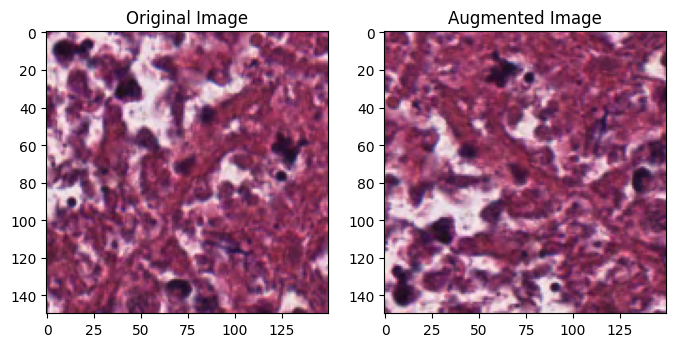

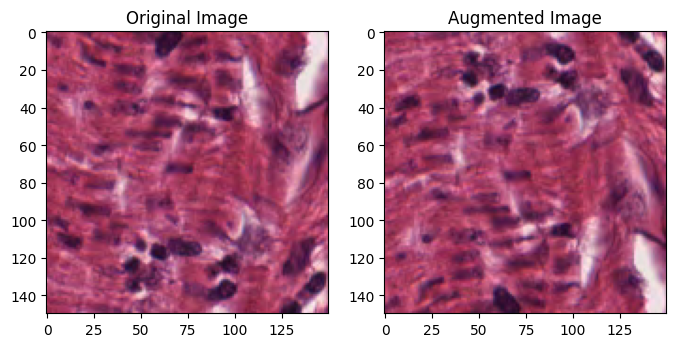

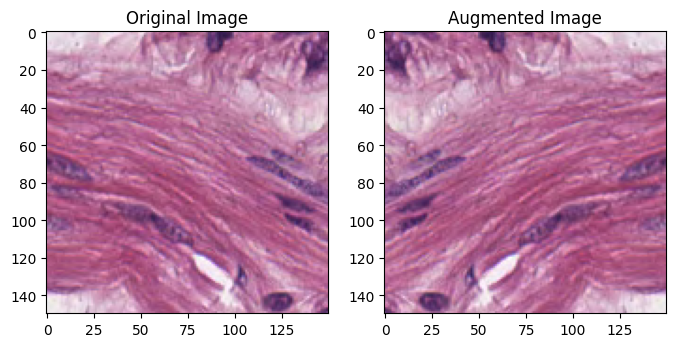

In [25]:
# Try out your augmentation technique here to see if it works!
for image in X_train[:3]:
  f, ax = plt.subplots(ncols=2, figsize=(8, 4))
  ax[0].imshow(image)
  ax[0].set_title('Original Image')
  augmented_image = create_random_augmented_image(image)
  ax[1].imshow(augmented_image)
  ax[1].set_title('Augmented Image')
  plt.show()

### 2.2.2. Discussion Exercise: Where to Use Augmentation


In [ ]:
#@title {"display-mode":"form", "form-width":"25%"}
#@markdown *Now that we've learned how to apply augmentations, we need to think about where we should use it. What data do we want to apply our augmentation function to?*

answer = "X_train" #@param ["X_train", "y_train", "all training data", "X_test", "y_test", "all test data", "all data", "Choose from the dropdown!"]

if answer == "X_train":
  print("Yes! We want to augment our training images, but not our training labels.\nNote that it's ONLY our training images. We leave our test data alone.")
else:
  print("Try again!")

### 2.2.3. Coding Exercise: Expanding Our Dataset


Finish the for loop that takes in our images and applies the `create_random_augmented_image()` function to create a new image. Make sure to append the newly created image and its associated label to the `X_train_augment_list` and the `y_train_augment_list`, respectively.

In [26]:
# Create two empty lists to hold our new data
X_train_augment_list = []
y_train_augment_list = []

# Loop through the images to create an augmented dataset
for i in range(len(X_train)):

    # Get the original image and its label
    original_image = X_train[i]
    original_label = y_train[i]

    # Create a new, randomly augmented version of the image

    ### WRITE YOUR CODE BELOW: Replace the Nones ###
    new_augmented_image = create_random_augmented_image(original_image)

    # Append the new image and its original label to our lists
    X_train_augment_list.append(new_augmented_image)
    y_train_augment_list.append(original_label)
    ### END CODE HERE ###

# Convert the lists to NumPy arrays
X_train_augment = np.array(X_train_augment_list)
y_train_augment = np.array(y_train_augment_list)

# Concatenate the original and augmented data to form our combined dataset
X_train_combined = np.concatenate((X_train, X_train_augment), axis=0)
y_train_combined = np.concatenate((y_train, y_train_augment), axis=0)

# Verify the new shapes
print("Dimensions of original X_train:", X_train.shape)
print("Dimensions of augmented X:", X_train_augment.shape)
print("Dimensions of combined X_train:", X_train_combined.shape)
print("Shape of combined y_train:", y_train_combined.shape)

Dimensions of original X_train: (768, 150, 150, 3)
Dimensions of augmented X: (768, 150, 150, 3)
Dimensions of combined X_train: (1536, 150, 150, 3)
Shape of combined y_train: (1536, 8)


## **2.3. Retraining the Model on Our Expanded Dataset**

### 2.3.1. Coding Exercise



Remake and train your model (`cnn`) for 20 epochs using your new augmented dataset.

Use your testing data as validation to look at model performance as it trains.

Does the augmented dataset improve performance? Why or why not?

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.1397 - categorical_crossentropy: 2.0866 - loss: 2.0866 - val_accuracy: 0.3047 - val_categorical_crossentropy: 1.8223 - val_loss: 1.8223
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3153 - categorical_crossentropy: 1.7671 - loss: 1.7671 - val_accuracy: 0.3906 - val_categorical_crossentropy: 1.4588 - val_loss: 1.4588
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3575 - categorical_crossentropy: 1.5977 - loss: 1.5977 - val_accuracy: 0.4492 - val_categorical_crossentropy: 1.3360 - val_loss: 1.3360
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3964 - categorical_crossentropy: 1.4479 - loss: 1.4479 - val_accuracy: 0.4648 - val_categorical_crossentropy: 1.2979 - val_loss: 1.2979
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4518 - categorical_crossentropy: 1.3049 - loss: 1.3049 - val_accuracy: 0.5391 - val_categorical_crossentropy: 1.2710 - val_loss: 1.

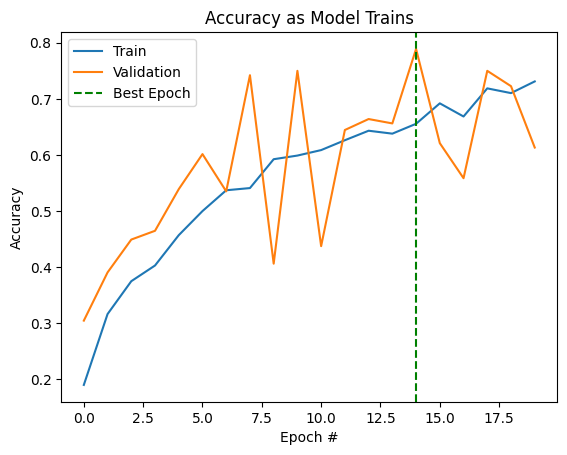

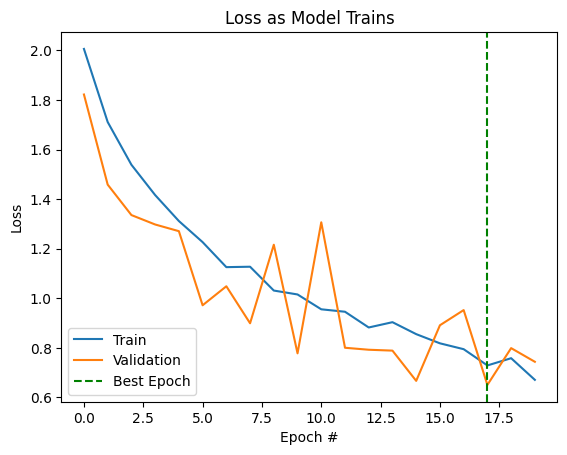

In [27]:
cnn = construct_model()
### WRITE YOUR CODE BELOW
additional_history = cnn.fit(X_train_combined, y_train_combined, validation_data=(X_test, y_test), epochs=20)
plot_metric(additional_history) # Example of Accuracy
plot_metric(additional_history, metric="loss", best_is_max=False) # Example of loss


### 2.3.2. Discussion Exercise

Let's compare the performance of our two models. Look at the accuracy and loss plots from the baseline model and compare them to the new plots from the model trained with augmented data.


In [ ]:
# @title {"display-mode":"form", "form-width":"25%"}
#@markdown *1. What was the best validation accuracy your baseline model achieved?*
answer1 = "" # @param {type:"string"}

#@markdown *2. What was the best validation accuracy this new, augmented model achieved? Did data augmentation improve the model's performance?*
answer2 = "" # @param {type:"string"}

#@markdown *3. Looking at the new plot, the validation accuracy is still quite "noisy" and jumps around between epochs. What does this tell you about the model and the difficulty of the problem?*
answer3 = "" # @param {type:"string"}

handle_discussion_response(answer1, answer2, answer3)

When you compare the two training runs, you should notice something very important:

 - **Training Accuracy** (the blue line on the new plot) climbs very high. This means the model got very good at classifying the training images, including the new augmented ones.
 - **Validation Accuracy** (the orange line), however, is very unstable and does not show significant improvement. Its peak performance is not a major leap over the baseline model and is highly erratic.


**Why did this happen?**

While we gave the model more data to learn from, our simple CNN architecture is still not powerful enough to find the truly robust, underlying patterns in such complex images.

**What's next?**

This result proves that simply adding more data isn't always enough if the model's architecture isn't sophisticated enough. We need a **better model**.

This perfectly sets the stage for our next technique, **Transfer Learning**, where we will use a much more powerful, pre-trained "expert" model to see if it can learn from this complex data without overfitting.

---
---
# **🧠 Milestone 3: Improving our Model with Transfer Learning**

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/a/ab/Transfer_Learning.png" width=500>
</center>




No matter what the image classification task, we expect certain **geometric features** to be important - lines, edges, shapes, etc. We also expect convolutional neural networks to learn to recognize these shapes (most likely in the earlier layers) throughout their training. Therefore, we might be able to re-use the layers/weights (that presumably encode for recognizing lines, edges, etc.) that one image classification task has learned to perform another.

Many groups have published large neural networks trained on millions of images for classification tasks - Resnet, AlexNet, and MobileNet are a few famous ones. In order to perform transfer learning we can
1. Download one of these pretrained models - their weights have already been learned.
2. Change the output layer to have the number of nodes appropriate for our classification task (# of classes). Optionally, change the structure of any additional later layers you might want to alter.
3. Freeze the weights of most of the layers, especially the initial first few layers. This is an option you can specify before training the model, and will prevent model training from changing any of those weights. Don't freeze the last layer.
4. Alter your training images so that they are the right size for the input size of the downloaded neural network.
5. Train the model on your images/labels!


## **3.1. Initialize a pre-trained model**

For our transfer learning, we're going to use an "expert" model built upon the famous **ImageNet** classification problem.

In ImageNet, participants were challenged to build machine learning models that could distinguish millions of images across more than 20,000 categories.

Below, we see examples of 3 different categories.

<center>
<img src="https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%206%20-%2010%20(Projects)/ImageNet.jpg">
</center>

While a model trained on ImageNet hasn't seen histology slides, it has learned to recognize fundamental patterns like edges, textures, and shapes. Transfer learning allows us to leverage this foundational knowledge and "fine-tune" it on our smaller, specialized medical dataset. This is often more effective than training a model from scratch, especially when working with limited medical data.


### 3.1.1. Discussion Exercise

Run the next cell to initialize the powerful ResNet50 model.


In [28]:
# Run this cell to import pretrained ResNet
from tensorflow.keras.applications import ResNet50
res_net = ResNet50(include_top=True)
res_net.summary()

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

Analyzing the summary from the previous code cell, answer the following questions!

In [ ]:
# @title {"display-mode":"form", "form-width":"25%"}
#@markdown *1. What is the input size (height, width, channels) of the images that ResNet50 expects?*
answer1 = "" # @param {type:"string"}

#@markdown *2. By default, how many different categories of images does this ResNet50 model classify? (Hint: Look at the last layer).*
answer2 = "" # @param {type:"string"}

#@markdown *3. How many total weights (parameters) did ResNet50 learn when it was originally trained?*
answer3 = "" # @param {type:"string"}

handle_discussion_response(answer1, answer2, answer3)

### 3.1.2. Coding Exercise: Customizing the Transfer Model


Now that we've taken a look at the overall model, let's edit it so we can train it for our own task. We want to retain the majority of the network, but, as you discussed in the last exercise, the last layer will not be suitable for our task.

Since this model was pre-built, we'll use a slightly different approach to build our own network off of it. Specifically, we want to keep most of the network but cut off the final classification layer and add our own. To do that, we need to grab the **output of an intermediate layer** inside the existing model. The **Sequential API** we've been using so far doesn't support this kind of operation — it only allows you to build models layer-by-layer from scratch, in a straight line.

The **Functional API**, on the other hand, gives us the flexibility to tap into any layer, reroute the input and output, and build a new model using pieces of the original one. Take a look at the first few lines of code below to see an example of that; the output of the network we're building up is passed as an input to the next layer.

Your only task is to create our output layer below with:
- the # of nodes appropriate for our classification task
- the activation function needed to make sure the outputs are probabilities

After doing this, run the cell and look at the final layer in your model summary. Does it have the number of neurons that you would like?

In [29]:
from tensorflow.keras import Model

# Get ResNet's output from the layer before the last Dense layer, and add on a
# custom Dense layer and Dropout layer
output_from_resnet = res_net.layers[-2].output
x = Dense(128, activation='relu')(output_from_resnet)
x = Dropout(0.50)(x) # Add 50% dropout

### WRITE YOUR CODE BELOW: Replace the Nones! ###
new_output_layer = Dense(8, activation='softmax')(x)
### END CODE HERE ###

# The next couple lines are necessary to build the complete network using the
# majority of the ResNet50 network as well as our custom layers from above.
input = res_net.input
transfer_cnn = Model(input, new_output_layer)

# Print the summary
transfer_cnn.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,016 (90.98 MB)

 Trainable params: 23,797,896 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

### 3.1.3. Coding Exercise: Freezing the Weights We Want to Keep



Next, freeze the weights for all of the layers except for the final layer. You can do this for the `layer` you're interested by setting `layer.trainable=False` (that is, make them no longer trainable)

Additionally, compile your model and look at its summary. Now, how many trainable parameters (weights) are there compared to before?

In [30]:
# Make all layers untrainable by freezing weights (except for last layer)
for layer in transfer_cnn.layers:
  ### WRITE YOUR CODE BELOW: Make all the layers untrainable to start
  layer.trainable=False
  ### END CODE HERE ###

## Set the final three layer as trainable=True
for layer in transfer_cnn.layers[-3:]:
  ### WRITE YOUR CODE BELOW: Now set our last few layers to be trainable
  layer.trainable=True
  ### END CODE HERE ###

### WRITE YOUR CODE BELOW ####
# Compile your new model using loss='categorical_crossentropy'
# optimizer='adam' and metrics=['accuracy', 'categorical_crossentropy']
transfer_cnn.compile(loss='categorical_crossentropy', optimizer='adam',
                     metrics=['accuracy', 'categorical_crossentropy'])
### END CODE HERE ###

# Look at the summary of the network to make sure the structure is as you expect!
transfer_cnn.summary()

Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,016 (90.98 MB)

 Trainable params: 263,304 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### 3.1.4. Discussion Exercise: Analyzing the Transfer Model Summary


In [ ]:
# @title {"display-mode":"form", "form-width":"25%"}
#@markdown *1. How many layers in our model are actually being trained? Do we see where the trainable weights are coming from (that is. do we see which layer is being trained?)*
answer1 = "" # @param {type:"string"}

#@markdown *2. Why do you think freezing the layers is a good idea? What might happen if we don't freeze them?*
answer2 = "" # @param {type:"string"}

handle_discussion_response(answer1, answer2)

### 3.1.5. Coding Exercise: Making Our Images Compatible with the Transfer Model


The transfer learning model we are using was trained using a certain size image. Additionally, the images were not normalized, so we will need to *rescale* the pixels values back to 0-255. We can do this by multiplying our images by 255.0.

Rescale and resize your images so that they are the appropriate format for the input layer of your model. You can use the function we have given you, which takes in a set of `images` and resizes them to have the appropriate `heights` and `widths`.

Look back at the previous model summaries if you don't remember the input ResNet50 is expecting!



In [31]:
from tensorflow.image import resize_with_pad

# Takes in an image, a new height, and a new width
# and resizes the image, plus converts from greyscale to 3 RGB color channels.
def ResizeImages(images, height, width):
  return np.array([resize_with_pad(image, height, width, antialias=True) for image in images]).astype(int)

X_train_unnormed = X_train * 255.0
X_test_unnormed = X_test * 255.0

### WRITE YOUR CODE BELOW: Resize your images by replacing the Nones
X_train_resized = ResizeImages(X_train_unnormed, 224, 224)
X_test_resized = ResizeImages(X_test_unnormed, 224, 224)
### END CODE HERE

# Make sure your images are the right dimensions
print("Dim X_train_resized:", X_train_resized.shape)
print("Dim X_test_resized:", X_test_resized.shape)

Dim X_train_resized: (768, 224, 224, 3)
Dim X_test_resized: (256, 224, 224, 3)


### 3.1.6. Coding Exercise: Finetune the Transfer Model with Our Data


Now we're finally ready to train the transfer model! Please train the model for 20 epochs using your data.

Use your testing data as validation to look at model performance as it trains.

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step - accuracy: 0.3667 - categorical_crossentropy: 2.1541 - loss: 2.1541 - val_accuracy: 0.8320 - val_categorical_crossentropy: 0.5949 - val_loss: 0.5949
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.7402 - categorical_crossentropy: 0.7759 - loss: 0.7759 - val_accuracy: 0.8594 - val_categorical_crossentropy: 0.4523 - val_loss: 0.4523
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.7961 - categorical_crossentropy: 0.5995 - loss: 0.5995 - val_accuracy: 0.8789 - val_categorical_crossentropy: 0.3842 - val_loss: 0.3842
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.8322 - categorical_crossentropy: 0.4605 - loss: 0.4605 - val_accuracy: 0.8750 - val_categorical_crossentropy: 0.3657 - val_loss: 0.3657
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 0.8664 - categorical_crossentropy: 0.3872 - loss: 0.3872 - val_accuracy: 0.8867 - val_categorical_crossentropy: 0.3636 - val_lo

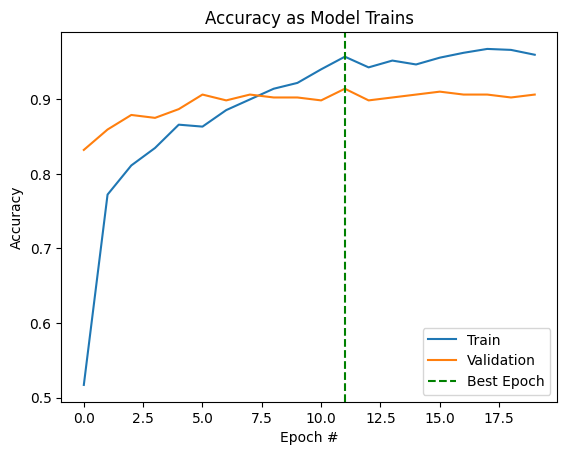

In [32]:
### WRITE YOUR CODE BELOW
transfer_history = transfer_cnn.fit(X_train_resized, y_train, validation_data=(X_test_resized, y_test), epochs=20)
plot_metric(transfer_history)


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step
              precision    recall  f1-score   support

     adipose       0.98      1.00      0.99        43
     complex       0.72      0.79      0.75        29
      debris       0.88      0.91      0.89        23
       empty       1.00      0.97      0.99        39
      lympho       0.81      0.85      0.83        20
      mucosa       0.90      0.87      0.89        31
      stroma       0.97      0.88      0.92        34
       tumor       0.92      0.89      0.90        37

    accuracy                           0.91       256
   macro avg       0.90      0.90      0.90       256
weighted avg       0.91      0.91      0.91       256



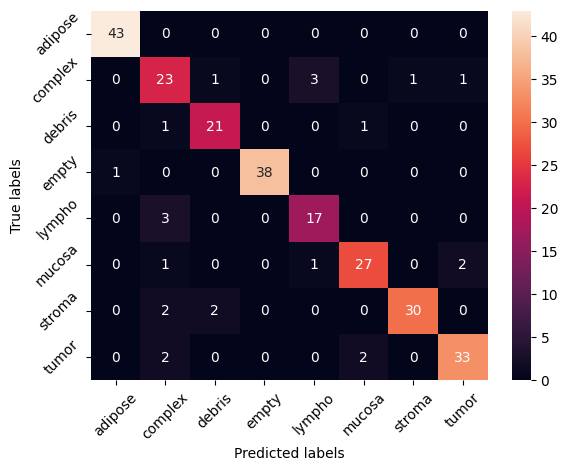

In [33]:
#@title Run this get our Confusion Matrix and Classification Report {"display-mode":"form", "form-width":"25%"}

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
logits = transfer_cnn.predict(X_test_resized)
vals = np.argmax(logits, axis=1)
y_pred = np.array([one_hot_encoding_to_label_dict[val] for val in vals])
y_true = np.array([one_hot_encoding_to_label_dict[y_val] for y_val in np.argmax(y_test, axis=1)])

sns.heatmap(pd.crosstab(y_true, y_pred), annot=True)
print(classification_report(y_true, y_pred))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

### 3.1.7. Discussion Exercise: Analyzing the Results



You have now evaluated the `ResNet50` model. Let's compare its performance to the baseline model from Notebook 2 and assess its clinical potential.


In [ ]:
# @title {"display-mode":"form", "form-width":"25%"}
#@markdown *1. **Overall Performance Gain**: Compare the overall accuracy of this ResNet50 model to the baseline CNN from Notebook 2. What does this immediate and significant improvement tell you about the power of transfer learning for complex problems like this?*
answer1 = "" # @param {type:"string"}

#@markdown *2. **Analyzing the `tumor` Class (Clinical Priority)**: Let's focus on the most critical task. How have the **precision** and **recall** for the `tumor` class changed from the baseline model to this new model?*
answer2 = "" # @param {type:"string"}

#@markdown *3. **Diagnosing Strengths and Weaknesses**: Look at the F1-scores for all tissue types.*
#@markdown - *Which classes saw the biggest improvement compared to the baseline model?*
#@markdown - *Are there any classes that the powerful `ResNet50` model still struggles with (i.e., it has the lowest F1-scores)? Why do you think some classes remain challenging even for an advanced model?*
answer3 = "" # @param {type:"string"}

#@markdown *4. **Final Clinical Readiness Verdict**: Considering the significant performance boost, is this `ResNet50` model ready for clinical use? If not, what specific weaknesses (e.g., lingering confusion between certain classes, recall for a critical tissue type) still need to be addressed before you would be comfortable with it assisting a pathologist? How might you improve the model performance?*
answer4 = "" # @param {type:"string"}

handle_discussion_response(answer1, answer2, answer3, answer4)

---
---
# **🤔 Milestone 4: Model Interpretability with Grad-CAM**

Our transfer learning model achieved high accuracy, but in medicine, a correct prediction isn't enough. For a doctor to trust an AI, they need to understand why it made a certain decision. This is the challenge of interpretability. Is the model looking at clinically relevant features (like the shape and clustering of cell nuclei), or is it cheating by focusing on irrelevant artifacts in the image?

To answer this, we'll use a powerful technique called Grad-CAM (Gradient-weighted Class Activation Mapping). Grad-CAM produces a "heatmap" that highlights the regions of the image the model paid the most attention to when making its prediction.

 - Bright Red/Yellow Areas: The most important regions for the model's decision.

 - Blue/Green Areas: Less important regions.

By comparing these heatmaps for both correct and incorrect predictions, we can gain crucial insights into our model's "thinking process."

Run the code below to generate Grad-CAM visualizations. Then, discuss the following questions with your group:

 - For the correctly predicted images: Do the heatmaps highlight the actual tissue structures you would expect to be important for the diagnosis? For example, in a `tumor` image, is the model focusing on the dense, irregular cancer cells?

 - For the incorrectly predicted images: Where is the model looking? Is it focusing on a confusing or ambiguous part of the image, or is it getting distracted by something completely irrelevant?

**Building Trust**: Based on these visualizations, how much would you trust this model as a diagnostic assistant? What do the heatmaps reveal about its strengths and weaknesses?

## **4.1. Interactive Model Interpretability: Grad-CAM**

In [35]:
#@title Analyze a Tissue Type {"display-mode":"form", "form-width":"25%"}
#@markdown Select a tissue type from the dropdown menu to analyze the model's performance.
#@markdown The tool will first look for an instance where the model misclassified this tissue.
#@markdown - **If a mistake is found,** it will show you the error, then show correct examples of the two confused classes for comparison.
#@markdown - **If no mistakes are found,** it will simply show you 5 correct examples of the selected tissue type.

# --- Create the Dropdown Menu ---
# This list now matches the actual class names used by the model.
class_names_for_dropdown = ['adipose', 'complex', 'debris', 'empty', 'lympho', 'mucosa', 'stroma', 'tumor']
selected_tissue_type = 'tumor'  #@param ["adipose", "complex", "debris", "empty", "lympho", "mucosa", "stroma", "tumor"]

# --- Step 1: Initial Model and Prediction Setup ---
# Find the name of the last convolutional layer in the transfer learning model
last_conv_layer_name = None
for layer in reversed(transfer_cnn.layers):
    if 'conv' in layer.name:  # A more robust way to find a convolutional layer
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    raise ValueError("Could not find a Conv2D layer in the model.")

# Get predictions for the entire test set
all_preds = transfer_cnn.predict(X_test_resized, verbose=0)
predicted_indices = np.argmax(all_preds, axis=1)
true_indices = np.argmax(y_test, axis=1)

# Create a mapping from class index to class name for display
class_names = sorted(pd.get_dummies(labels).columns)

# --- Step 2: Find a Misclassification for the Selected Tissue Type ---
target_class_index = class_names.index(selected_tissue_type)

# Find all indices where the true label is our target, but the prediction was wrong
misclassification_indices = np.where((true_indices == target_class_index) & (predicted_indices != target_class_index))[0]

# --- Step 3: Visualize Based on Whether a Mistake was Found ---
if len(misclassification_indices) > 0:
    # SCENARIO A: A mistake was found.
    mistake_index = misclassification_indices[0]  # Focus on the first mistake

    true_label = class_names[true_indices[mistake_index]]
    predicted_label = class_names[predicted_indices[mistake_index]]

    print(f"Found a misclassification for '{selected_tissue_type}'.")
    print(f"The model incorrectly predicted '{predicted_label}' when the true label was '{true_label}'.")
    print("\n--- Visualizing the Specific Error ---")
    plot_single_gradcam(mistake_index, transfer_cnn, last_conv_layer_name, class_names, X_test_resized, y_test)

    # Find and visualize 5 correct examples of what the model THOUGHT it saw
    print(f"\n--- For comparison, here are 5 correct examples of '{predicted_label}' ---")
    correct_predicted_indices = np.where((true_indices == class_names.index(predicted_label)) & (predicted_indices == true_indices))[0][:5]
    for i in correct_predicted_indices:
        plot_single_gradcam(i, transfer_cnn, last_conv_layer_name, class_names, X_test_resized, y_test)

    # Find and visualize 5 correct examples of what the model SHOULD have seen
    print(f"\n--- And here are 5 correct examples of the true class, '{true_label}' ---")
    correct_true_indices = np.where((true_indices == target_class_index) & (predicted_indices == true_indices))[0][:5]
    for i in correct_true_indices:
        plot_single_gradcam(i, transfer_cnn, last_conv_layer_name, class_names, X_test_resized, y_test)

else:
    # SCENARIO B: No mistakes were found.
    print(f"No misclassifications found for '{selected_tissue_type}' in the test set! The model was correct every time.")
    print(f"\n--- Showing 5 correctly identified examples of '{selected_tissue_type}' ---")

    correct_indices = np.where((true_indices == target_class_index) & (predicted_indices == true_indices))[0][:5]
    if len(correct_indices) == 0:
        print(f"Could not find any examples of '{selected_tissue_type}' in the test set.")
    else:
        for i in correct_indices:
            plot_single_gradcam(i, transfer_cnn, last_conv_layer_name, class_names, X_test_resized, y_test)

Output hidden; open in https://colab.research.google.com to view.

### 4.1.1. Discussion Exercise
You've now seen a detailed breakdown of a specific error the model made. By comparing the model's focus during its mistake with its focus for correct predictions, you can gain a much deeper understanding of its behavior. Discuss the following questions with your group.

1. **Diagnosing the Mistake**: Look at the very first heatmap showing the incorrect prediction. Where is the model focusing its attention (the bright red/yellow areas)? Based on the visual evidence in that specific image, why do you think the model got confused and chose the wrong label?

2. **Comparative Analysis**: Now, carefully compare the two sets of correctly identified images: the class the model thought it saw versus the class it should have seen.

 - What features does the model consistently focus on for each class when it gets them right?

 - Are there visual similarities between the key features of these two tissue types that might explain the model's confusion?

3. **Building Trust and Next Steps**: Does seeing this specific breakdown of an error—and why it likely happened—increase or decrease your trust in the AI as a diagnostic assistant? If you were to continue improving this model, what would be your next step to help it better distinguish between these two specific classes it confused?

---
---
# 🎁 Wrapping Up

Congratulations! You have successfully built, evaluated, and improved a deep learning model for a real-world problem in precision medicine. You started with a basic CNN, then enhanced it with expert-level techniques like transfer learning, and finally, you peeked inside the "black box" using Grad-CAM to understand its decision-making process.

In this final section, you will synthesize everything you've learned to form a concluding analysis of your AI model's potential and its place in the future of medicine.



### Discussion Exercise


Discuss the following questions with your group, preparing a summary of your findings as if you were presenting them to a hospital's research board:

1. **The Impact of Advanced Techniques**: How did Transfer Learning and Data Augmentation improve upon the baseline model from Notebook 2? Referencing your accuracy graphs and evaluation metrics, explain why these techniques are essential for medical imaging tasks, which often suffer from limited data.

2. **Interpretability and Building Trust**: Review your Grad-CAM results for the incorrectly predicted images. Did the model's "focus" give you clues as to why it made those mistakes? How does the ability to "see what the model sees" help a pathologist or clinician build trust in an AI assistant?

3. **Putting the "Precision" in Precision Medicine**: A key goal of precision medicine is to move beyond one-size-fits-all treatments. If this AI model were deployed in a hospital, how could its tissue classifications be combined with other patient data (like genomic information, family history, or blood test results) to recommend a truly personalized treatment plan?

4. **From Lab to Clinic - The Next Steps**: If you were a researcher with a new grant, what would be your single most important next step to improve this model and move it closer to real-world clinical use? (e.g., collect more diverse patient data, try a more advanced model architecture like Vision Transformer, or design a small-scale clinical trial). Explain your choice.

<center>
<img src="https://c.pxhere.com/photos/04/45/fireworks_celebration_bright_pink_explosive_celebrate_display_july_4th-1160027.jpg!d" width=500>
